In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm
from copy import deepcopy
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, log_loss
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split

import gc
# from numba import cuda

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
simulations = np.load('/content/drive/MyDrive/simulations1.npy', allow_pickle=True)
dataset = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# N = simulations.shape[0]
N = 500
X = torch.from_numpy(simulations[:N].reshape(N, 1, 513, 513)).float().to(device)
y = torch.from_numpy(dataset[:N].reshape(N, 1, 513, 513)).float().to(device)

In [5]:
del simulations
del dataset

In [6]:
def train(model, criterion, optimizer, X, y, n_epochs, n_stop=10):
    bs = 10
    # total_size = dataset.shape[0]
    # train_dataset, val_dataset, test_dataset = random_split(dataset, 
                                            # [int(total_size * 0.7), int(total_size * 0.2), int(total_size * 0.1)])
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=bs)
    val_loader = DataLoader(val_data, batch_size=bs)
    test_loader = DataLoader(test_data, batch_size=bs)

    # train_loss = list()
    # val_loss = list()
    min_val_loss = np.inf
    f = 0
    t0 = default_timer()
    for epoch in range(n_epochs):
        t1 = default_timer()
        model.train()
        # train_batch_loss = list()
        # mean_train_batch_loss = 
        for batch in train_loader:
            optimizer.zero_grad()
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            _y_pred = model(_X).view(-1, 513, 513)
            # print(_y_pred.size(), _y.size())
            loss = criterion(_y_pred, _y)
            loss.backward()
            optimizer.step()
            # train_batch_loss.append(loss.item())

        model.eval()
        # val_batch_loss = list()
        mean_val_loss = 0
        batch_count = 0
        for batch in val_loader:
            _X, _y = batch
            _X, _y = _X.to(device), _y.to(device)
            _y_pred = model(_X).view(-1, 513, 513)
            loss = criterion(_y_pred, _y)
            mean_val_loss += loss.item()
            batch_count += 1
            # val_batch_loss.append(loss.item())
        mean_val_loss /= batch_count
        t2 = default_timer()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} ({round(t2-t1, 3)}s, {round(t2-t0, 3)}s), \tValidation loss: {(mean_val_loss)}')
        # train_loss.append(np.mean(train_batch_loss))
        # val_loss.append(np.mean(val_batch_loss))
        # val_loss = np.mean(val_batch_loss)
        # (optional) early stopping:

        if round(mean_val_loss, 3) >= min_val_loss:
            f = f + 1
        else:
            # print(f'epoch: {epoch}, val loss did decrease, saving model')
            f = 0
            best_model = deepcopy(model)
            min_val_loss = round(mean_val_loss, 3)
        if f >= n_stop:
            print(f'epoch: {epoch}, val loss did not decrease for {f} epoch(s)')
            break

    return best_model #, train_loss, val_loss

In [7]:
!nvidia-smi

Fri May  5 13:53:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |   1603MiB / 15360MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Define the CNN architecture
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
    self.fc1 = torch.nn.Linear(64 * 128 * 128, 128)
    self.fc2 = torch.nn.Linear(128, 513 * 513)

  def forward(self, x):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)
    x = x.view(-1, 64 * 128 * 128)
    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)
    return x

In [9]:
# Instantiate the CNN
model = CNN().to(device)
model.cuda()

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train(model, criterion, optimizer, X, y, n_epochs=10000, n_stop=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 1, 513, 513])) that is different to the input size (torch.Size([10, 513, 513])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 (12.235s, 12.235s), 	Validation loss: 14982.55234375
Epoch: 10 (4.995s, 62.038s), 	Validation loss: 10987.359765625
epoch: 11, val loss did not decrease for 10 epoch(s)


In [10]:
# plt.plot(train_loss, label='train loss')
# plt.plot(val_loss, label='validation loss')
# plt.legend()
# plt.ylabel('CE Loss')
# plt.xlabel('# of epoch')
# plt.show()

In [18]:
from PIL import Image

In [20]:
circle_np = np.array(Image.open('/content/grayscale_circle.png').convert("L"))
circle =  torch.from_numpy(circle_np.reshape(1, 513, 513)).float().to(device)
circle_pred = model(circle).view(-1, 513, 513)

In [13]:
def frame_plot(arr, ax):
  rectX = np.linspace(0, 1, arr.shape[0])
  rectY = np.linspace(0, 1, arr.shape[1])
  x, y = np.meshgrid(rectX, rectY)
  ax.pcolormesh(x, y, arr)

In [14]:
circle_pred_np = circle_pred.cpu().detach().numpy().reshape(513, 513)

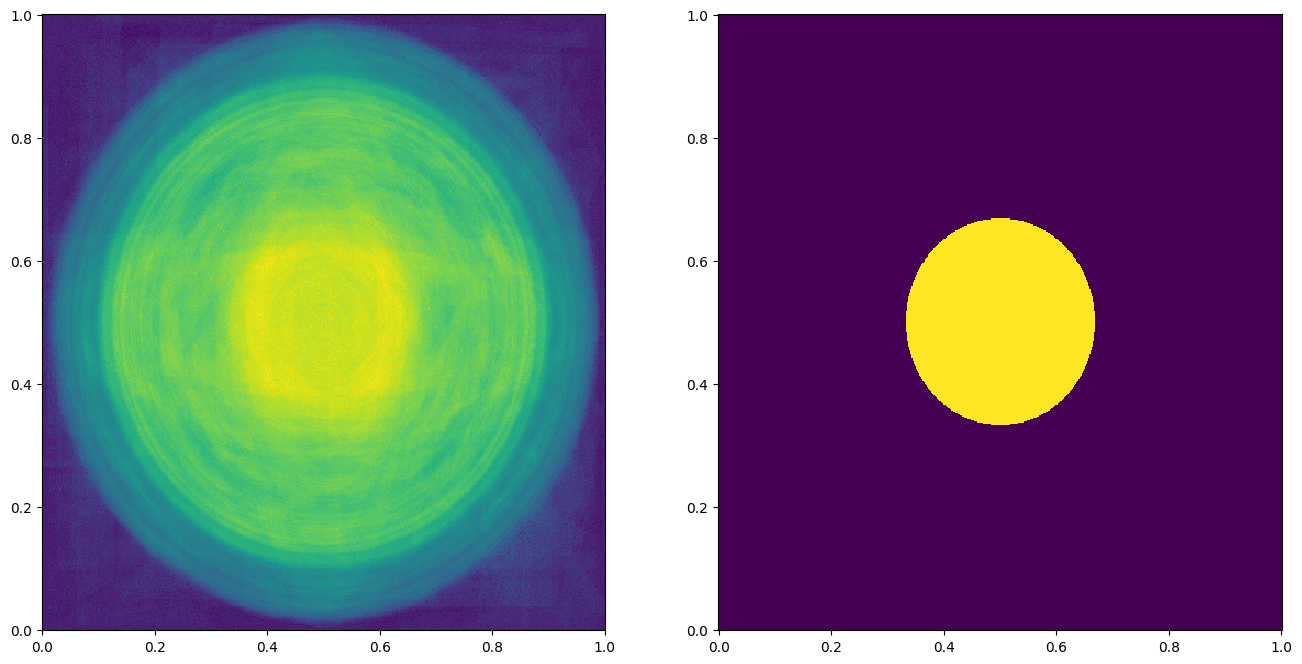

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(circle_pred_np, ax=ax[0])
frame_plot(circle_np, ax=ax[1])

In [16]:
circle_pred_np

array([[  26.56228  ,   25.609066 , -150.25125  , ...,   72.67903  ,
          47.528767 ,  -20.103794 ],
       [ -59.13113  ,   -1.2681098,   19.156351 , ...,   37.34177  ,
         -64.909065 ,   46.626354 ],
       [-168.18257  ,   58.785507 ,  -23.73308  , ...,   19.501938 ,
        -265.06094  ,  -36.13054  ],
       ...,
       [  -7.5071254,  -24.868261 ,  -82.687355 , ...,   61.80642  ,
          40.794903 ,   -9.808031 ],
       [  82.74756  ,   93.842636 ,   34.61159  , ...,  112.76679  ,
          37.634956 , -171.35263  ],
       [  47.49417  ,  -75.256386 ,   60.289223 , ...,   73.803085 ,
          89.089    , -105.24302  ]], dtype=float32)

In [17]:
circle_im = Image.fromarray(circle_pred_np)
circle_im = circle_im.convert('L')
circle_im.save('/content/circle_pred.png')